# Reproducing Calvano et al. (2020)
## Baseline - Stat des - Profits
### Author: Andréa Epivent

In [1]:
# Import relevant packages
import os
import numpy as np
import pandas as pd
import random
from IPython.display import clear_output
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
# Set working directory
path = "/Users/admin/Desktop/PhD/RL_AlgorithmicCollusion"

In [3]:
# Import our custom functions
os.chdir(path+"/Functions")
from find_state import find_rowindex
from profitquantity import quantity_compute, profit_compute, extra_profit_compute
from prices import get_last_price, get_forward_price

# Import parameters
exec(open("parameters.py").read())

In [4]:
# Import data from training
q_table_1 = np.load(path+'/Output/Baseline/q_table_a1.npy')
q_table_2 = np.load(path+'/Output/Baseline/q_table_a2.npy')
q_info = np.load(path+'/Output/Baseline/q_info.npy')
A = np.load(path+'/Output/Baseline/actions.npy')
S = np.load(path+'/Output/Baseline/states.npy')
n_iterations = np.load(path+'/Output/Baseline/n_iterations.npy')

### Analysis of extra-profit gains

#### Retrieve extra-profit gains

In [5]:
profit_M = profit_compute(p_M,p_M,ci,ai,mu,a0) # Monopoly profit
profit_N = profit_compute(p_N,p_N,ci,ai,mu,a0) # B-N profit

# Using final price
price1, price2 = get_last_price(1,q_info,n_iterations)

extra_profit = np.zeros((n_episodes,))
for j in range(n_episodes):
    extra_profit[j] = extra_profit_compute(price1[j][0],price2[j][0],ci,ai,mu,a0,profit_M,profit_N)
    
# Using 10 forward price
f_price1, f_price2 = get_forward_price(10,q_table_1,q_table_2,q_info,n_iterations,S,A)

n_prices = 10
f_extra_profit = np.zeros((n_episodes,n_prices))
for j in range(n_episodes):
    for i in range(n_prices):
        f_extra_profit[j,i] = extra_profit_compute(f_price1[j][i],f_price2[j][i],ci,ai,mu,a0,profit_M,profit_N)

f_extra_profit = f_extra_profit.mean(axis=1)

In [22]:
# Save for later use
np.save(path+'/Output/Baseline/extra_profit', extra_profit)
np.save(path+'/Output/Baseline/f_extra_profit', f_extra_profit)

#### Descriptive statistics

* Processing

In [7]:
# Concatenate info in dataframe
df_extra_profit = pd.DataFrame(extra_profit,columns=["(Last) Extra profit"])
df_extra_profit["Forward mean extra profit"] = f_extra_profit

* Descriptive statistics for single final price (Figure 5)

Text(0, 0.5, '(Last) Extra profit')

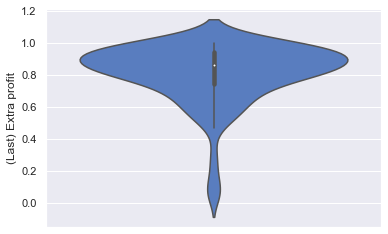

In [8]:
ax = sns.violinplot(y="(Last) Extra profit",data=df_extra_profit,palette="muted")
plt.ylabel('(Last) Extra profit')

* Descriptive statistics averaging forward 10 prices

Text(0, 0.5, 'Forward mean extra profit')

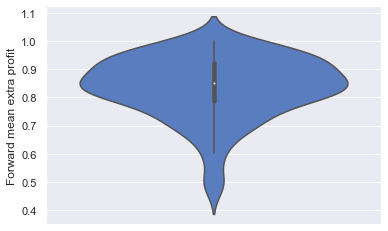

In [9]:
ax = sns.violinplot(y="Forward mean extra profit",data=df_extra_profit,palette="muted")
plt.ylabel('Forward mean extra profit')

### Evolution of industry profit through iterations

#### Retrieve industry profit

In [10]:
profit_a1 = q_info[:, 2::4]
profit_a2 = q_info[:, 3::4]
industry_profit = profit_a1+profit_a2

* Processing

In [20]:
df_profit_all = pd.DataFrame(industry_profit)
# replace 0 with missing values
df_profit_all.replace(0, np.nan, inplace=True) 
# average industry profit over episode
df_profit_all_mean = pd.DataFrame(np.array(df_profit_all.mean(axis=1)),columns=["profit"])
df_profit_all_mean["time"] = df_profit_all_mean.index
# Multiply by 1000
df_profit_all_mean["profit"] = df_profit_all_mean["profit"]*1000

# /!\ Caution: most episodes have converged before criterion_final is hit, risk of avering with 
# very few observations towards the end
# Remove last observations - biased
# Use median of n_iterations
df_profit_all_mean = df_profit_all_mean.head(int(np.quantile(n_iterations, 0.5)))

* Descriptive statistic (Figure 4)

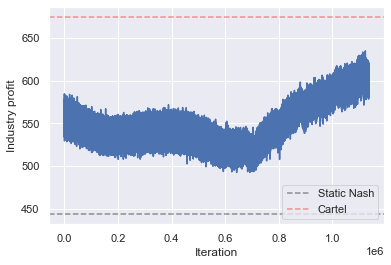

In [21]:
graph = sns.lineplot(data=df_profit_all_mean, x="time", y="profit")
graph.axhline(443.38,alpha=0.4,ls="--",color="black",label="Static Nash")
graph.axhline(674.94,alpha=0.4,ls="--",color="red",label="Cartel")

plt.ylabel('Industry profit')
plt.xlabel('Iteration')

plt.legend(loc='lower right')